## Ski Type Prediction Using the Fourier Transform

#### Joachim Mjelde

#### Abstract

To fully utilize the features of my self-developed iOS ski-tracking app SkiForce (Mjelde, 2023), the app needs to know which type of ski the user is using. By using the onboard accelerometer of iPhones, I have collected real-world accelerometer data while skiing. I have used the Fourier Transform to convert the data from the time domain to the frequency domain and built a machine learning model predicting whether the user skied on a Giant Slalom ski or a Slalom ski. I used logistic regression to build the model, which achieved a high level of accuracy. Due to the limited size of the dataset, despite the good performance of the model, it is unclear how a model trained on more diverse data would perform. Further exploration would be needed for a definite conclusion. 


#### Introduction

Through my Computer Science Capstone, I have developed an iOS app utilizing the GPS and accelerometer of the iPhone to track your skiing. The app displays metrics related to GPS, including average and maximum speed achieved, metrics about altitude and vertical descent as well as displaying a map of where you skied. Similar apps have been developed earlier, but what sets SkiForce apart from other ski-tracking apps, is its ability to utilize the accelerometer on the phone to display metrics. This includes

1. Max and average g-force
2. Number of jumps you went over 
3. Accumulative time in air 
4. Number of turns 
5. Type of ski used

The last two are closely connected. By knowing which ski type was used, the app tweaks the parameters of the algorithm that counts how many turns the user did in order to give a more accurate number. While the user can input this information themselves, having a model classifying this in the background makes for a better user experience. For this, I built a machine learning model that uses accelerometer data as input. Before the data is fed into the model, it is transformed using the Fourier Transform. Using the transformed data the model outputs whether the user used a Giant Slalom ski or a Slalom ski. 

#### Methods

Data was collected over the course of the winter through the use of the accelerometer on my phone. I started recording at the top of the hill, placed my phone inside my speed suit, skied normally from top to bottom, and stopped recording. I used two different ski types when collecting data, Slalom and Giant Slalom. The main difference between the two skis is how quickly they turn. A Slalom ski has a radius of 13 meters and a Giant Slalom ski has a radius of 30 meters, meaning a slalom ski turns quicker than a Giant Slalom ski. Each run was saved locally on my phone with a note explaining which ski type I used. The accelerometer collected data 10 times a second. The data was imported into my computer after each day of skiing. All data was split into chunks of 20-second recordings (200 accelerometer inputs). All data can be found in data.csv. 

In [2]:
# All necessary imports 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd 
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, mean_squared_error
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq
from sklearn.metrics import roc_curve, auc

/Users/joachimmjelde/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
# import data
data = pd.read_csv("data.csv")
data.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,target
0,0.701767,0.505814,0.440445,0.525818,0.319962,0.195663,0.115616,0.041290,0.101349,-0.335876,...,-0.240219,-0.123932,-0.244705,-0.539917,-0.174026,-0.217896,-0.115601,-0.649353,-0.289261,gs
1,-0.558167,-0.109161,-0.221664,-0.229507,-0.071259,-0.151672,-0.041656,-0.000793,0.373825,0.240067,...,0.106308,0.221451,0.067276,0.432846,0.445923,0.356873,0.615189,0.150238,0.289963,gs
2,-0.023712,0.213577,-0.035248,0.086945,0.123413,0.589233,-0.140991,0.875198,0.146667,0.748978,...,0.101013,0.429321,0.059265,-0.068497,0.216064,0.391800,-0.125595,-0.128265,0.204514,gs
3,0.587753,0.549484,0.625244,0.450912,0.716599,0.627670,0.733093,1.008331,0.682587,0.454895,...,-0.008926,0.111771,0.234238,-0.143051,0.044220,-0.172501,-0.124939,0.078323,0.164139,gs
4,0.075699,-0.148056,-0.313751,-0.209122,-0.091049,-0.188263,0.143250,0.211700,0.303970,0.186951,...,0.690155,0.331863,0.264297,0.341690,0.195831,0.226669,0.121368,0.055099,0.517136,gs


In [17]:
# Shape of the data
data.shape

(36, 201)

The data consists of 24 runs of Giant Slalom and 12 runs of Slalom, equalling 36 rows. The 200 first columns are accelerometer inputs, the final column is the target. 

From here we convert the data from the time domain to the frequency domain using the Fourier Transform. 

In [12]:
# Transform data using Fourier Transform
# Returns dataframe of transformed data with targets

def transform_data(data):
    transformed_data = []
    targets = []
    for index in range(len(data)):
        row = data.iloc[index]
        targets.append(row[-1])
        transformed_data.append(np.abs(fft(row[:200])))
    transformed_data = pd.DataFrame(transformed_data)
    transformed_data['target'] = targets
    return transformed_data, targets

In [13]:
# data ready for model

transformed_data, targets = transform_data(data)

Data is transformed. A variety of models were tested and logistic regression performed the best. Due to the small size of the dataset, I used Leave-One-Out Cross Validation to test the model. 

In [16]:
# Leave-One-Out Cross Validation

X = transformed_data.drop('target', axis=1)
y = transformed_data['target']

cv = LeaveOneOut()
model = LogisticRegression()
pred =  cross_val_predict(model, X, y,
                         cv=cv, n_jobs=-1)
pred

/Users/joachimmjelde/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/joachimmjelde/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/joachimmjelde/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/joachimmjelde/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detect

array(['gs', 'gs', 'sl', 'gs', 'gs', 'gs', 'gs', 'gs', 'gs', 'gs', 'gs',
       'gs', 'gs', 'gs', 'gs', 'gs', 'gs', 'gs', 'gs', 'gs', 'gs', 'gs',
       'gs', 'gs', 'gs', 'sl', 'sl', 'sl', 'sl', 'gs', 'sl', 'sl', 'sl',
       'sl', 'sl', 'sl'], dtype=object)

Predictions made by the model.

#### Results

In [8]:
# Confusion Matrix
confusion_matrix(y, pred)

array([[23,  1],
       [ 2, 10]])

In [9]:
# Accuracy score
accuracy_score(y, pred)

0.9166666666666666

Accuracy score of 91.67%.

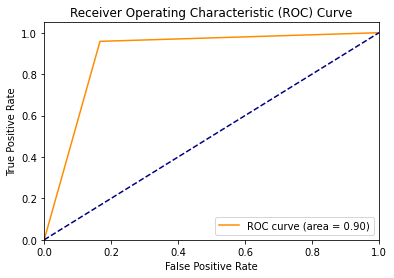

In [14]:
# ROC curve

pred_transformed = []
real_targets_transformed = []
for i in range(len(pred)):
    if pred[i] == 'sl':
        pred_transformed.append(0)
    else:
        pred_transformed.append(1)
        
    if targets[i] == 'sl':
        real_targets_transformed.append(0)
    else:
        real_targets_transformed.append(1)

fpr, tpr, thresholds = roc_curve(real_targets_transformed, pred_transformed, pos_label = 1)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ROC Curve showing the tradeoff between the true positive rate and the false positive rate. AUC value is 0.90. 

#### Discussion/Conclusion

The results show the model achieved a high level of accuracy, correctly classifying the ski types 91.67% of the time. Furthermore, the AUC value of 90% suggests that the model had a good overall performance in distinguishing between the two types. 

Even though the performance of the model is promising, there are some limitations that are worth noting. Firstly, the model is trained on a very limited dataset. With such a limited dataset, the full range of variability in unseen data the model could be exposed to has not been captured in the training data. This could heavily affect the performance of the model. Secondly, all the data was collected by me. Skiing is an individual sport meaning there are countless factors deciding how the data would look for different people. Their technique, height, weight, age, the stiffness of their ski, the stiffness of their boot, and how sharp their edges all decide how the accelerometer data of a turn would look. Capturing this variety would be close to impossible and beyond the scope of this project. Despite the model performing well on data collected by me, the model's performance could vary significantly if it were exposed to data collected by other people. Thirdly, the data was collected on mostly one type of snow. Since skiing is an outdoor sport, the snow conditions could vary greatly. The ski reacts very differently to powder compared to artificial snow, which would also change how the data looks. I did most of my data collection on newly groomed, soft snow in Park City, Utah. While the model performs well on this type of snow, it is uncertain it would perform as well if exposed to data collected on other snow conditions. 

In terms of further exploration, changing the model from a binary classifier to a multiclass classifier would open up the use case to a wider audience. As of now, the model caters mostly to ski racers or people that own racing skis. Making it a multiclass classifier it would be possible to add classes for skis that a hobby skier would use. How well this model would perform is unclear as the difference between the classes would narrow significantly. As of now, the difference in radius between the two ski types is 17 meters. If a new class with a 23 meter radius ski was added, the difference between the data would not be as large, potentially leading to a worse model. 

In conclusion, given the model's good performance, it can function as a proof of concept for similar models being built in the future. Large amounts of data collected over the course of an entire winter by a variety of people on all types of snow conditions would be needed to build a proper model. Having collected all the necessary data and trained a model on that data, it is still unclear how well that model would perform due to the wide variety of factors that can affect the data. Future exploration would be needed to verify the usefulness of such a model.

### Citations

1. Mjelde, J.(2023). SKiForce. Retrieved from https://github.com/jmjelde1/SkiForce